# Lab 04 : Modeling disease spread

In these trying times we have heard much about Covid-19 and its spread. We have all been involved in "flattening the curve". Many policy decisions have been (or should have been) made based on models. While we will not explore detailed models, nor consider parameters associated with Covid-19, we can consider a simple model which serves as a basis for much of the ongoing modelling. With this in hand, we could expand the model to more completely represent an actual disease.

## Initialization

Collect all your initialization here.  Make sure all figures are inlined by using `%matplotlib inline`.

In [2]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

## The SIR model

One of the simplest models is the SIR model which breaks the population into three groups: those who are (S)ucceptible, (I)nfected (or infectious), and (R)ecovered. For a population of $N$ people we will use normalized quantities in our study:

$$ s(t) = \frac{S(t)}{N}, \quad i(t) = \frac{I(t)}{N}, \quad r(t) = \frac{R(t)}{N}. $$

Note that these represent the percentage of the population in each group and they satisfy

$$ s(t) + i(t) + r(t) = 1 $$

at all times.

This simple model has many assumptions built-in that could all, in principle, be modified.
1. The population, $N$, is a constant. It ignores births, deaths, immigration, *etc*.
2. Similarly, no one is added to the succeptible group. This means $s(t)$ cannot increase.
3. Each infected person has a constant number of contacts per day, $\beta$, that are sufficient to spread the disease.
4. A constant fraction of infected people, $\gamma$, recover on a given day.

With these assumptions the model can be written as a system of coupled, ordinary differential equations that describes the evolution of each fraction of the population:

\begin{align}
 \frac{\mathrm{d}s(t)}{\mathrm{d}t} &= -\beta s(t) i(t), \\
 \frac{\mathrm{d}i(t)}{\mathrm{d}t} &= \hphantom{-}\beta s(t) i(t) - \gamma i(t), \\
 \frac{\mathrm{d}r(t)}{\mathrm{d}t} &= \hphantom{-}\gamma i(t).
\end{align}

If you study these equations, each term in them should make sense. These equations also have a form similar to what appears in the study of decay or reaction chains in physics and chemistry.

### Preliminary Study

Write a function to be passed to `scipy.integrate.solve_ivp` that can be used to solve the system of differential equations **in the order written above**. You should clearly document this function.

In [3]:
def sir_model(t, y, beta, gamma) :
    ### BEGIN SOLUTION
    """
    Return the RHS of the SIR model.
    The functions we integrate correspond to:
    y[0] = s
    y[1] = i
    y[2] = r
    """
    dydt = np.zeros_like(y)
    dydt[0] = -beta*y[0]*y[1]
    dydt[1] = beta*y[0]*y[1] - gamma*y[1]
    dydt[2] = gamma*y[1]
    
    return dydt
    ### END SOLUTION

As a first test to get a feeling for how the equations model the spread of disease we will consider the 1968 flu which hit New York City. This disease has an infectious period of about 3 days. We can use this to estimate
$$ \gamma = \frac{1}{3}. $$
We do not have a good way of estimating the number of contacts (see below) so will instead just choose
$$ \beta = \frac{1}{2}. $$

Suppose that we start with only 10 infected people in a population of 10 million people.
Construct a NumPy array, called `y0`, that contains the initial values $[s(0), i(0), r(0)]$.

(To be clear, every one must be in one of the groups. Since we are assuming no one has had the disease in the past, no one has recovered yet.)

In [4]:
### BEGIN SOLUTION
y0 = np.array([1-1.0e-6, 1.0e-6, 0.])
### END SOLUTION

Solve the system of differential equations for the three populations over a time scale of 150 days to see how the disease spreads over a time period of about 5 months. Produce a quick plot of the three populations.

(Though it is a quick plot, you should still label the three populations in the plot. You do not need to make the rest of the plot look nice.)

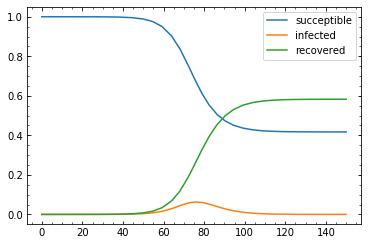

In [5]:
### BEGIN SOLUTION
sol = integ.solve_ivp( lambda t,y: sir_model(t, y, 1/2., 1/3.), (0, 150), y0,
                       atol=1.0e-6, rtol=1.0e-6 )

plt.plot(sol.t, sol.y[0], label='succeptible')
plt.plot(sol.t, sol.y[1], label='infected')
plt.plot(sol.t, sol.y[2], label='recovered')
plt.legend()
### END SOLUTION

To get a feeling for the role of the number of infectious contacts, $\beta$, let us keep $\gamma=1/3$ and see how $i(t)$ changes for $0.1\le\beta\le0.6$.

Produce a plot of $i(t)$ versus time for the different choices of $\beta$ in steps of 0.1. Make sure you solve for a sufficiently long time to show the behavior of the curves for all the values of $\beta$.

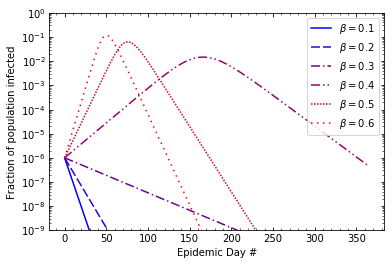

In [6]:
### BEGIN SOLUTION
colors = ['#0000FF', '#3300CC', '#660099', '#990066', '#CC0033', '#FF0000']
styles = ['solid', (0, (6, 2)), (0, (6, 2, 1, 2)), (0, (6,2,1,2,1,2)), (0, (1, 1)), (0, (1, 3))]
betas = np.linspace(0.1, 0.6, 6)
for n in np.arange(6) :
    sol = integ.solve_ivp( lambda t,y: sir_model(t, y, betas[n], 1/3.), (0, 365), y0,
                           atol=1.0e-12, rtol=1.0e-12, vectorized=True )

    plt.semilogy(sol.t, sol.y[1], color=colors[n], linestyle=styles[n], label=r'$\beta='+("%1.1f"%betas[n])+'$')

plt.ylim(1.0e-9, 1.0)
plt.xlabel('Epidemic Day #')
plt.ylabel('Fraction of population infected')
plt.legend()
### END SOLUTION

You should have found that the maximum number of infected people depends on $\beta$. In fact, there is a value of $\beta$ that, if we remain below this value, the disease will never spread. For this simple model this occurs if

$$ \left. \frac{\mathrm{d}i}{\mathrm{d}t} \right|_{t=0} \le 0, $$

or, using this along with the differential equations from earlier, for a value $\beta_{\rm min} = \frac{\gamma}{s(0)}$.

In case of a larger $\beta$, to not overwhelm hospitals, suppose that we want to keep the maximum of the infected people below some fraction. In this case, there would be some maximum $\beta$ we can withstand, which in turn would tell us something about how extreme our efforts should be to reduce $\beta$. (In other words, this would affect policy decisions. See below for a little more on this.)

To begin, we need to know how to find the maximum for $i(t)$. Given the importance of this we want to do this in a precise manner. Just using something like "max(i(t))" from our discretized solution could work, but is not ideal. Fortunately we can do better. Below, describe in words, and equations if needed, how you might accurately find a maximum value of $i(t)$ from a discretized solution to the system of differential equations.

```### YOUR ANSWER HERE```

```There are many acceptable methods. One way is to construct an interpolating function and maximize it. We can also compute the derivative and find a root, which we do below.```

Implement a function to calculate the maximum $i(t)$ for a given $\beta$, $\gamma$, and `y0`.  If $\beta\le\beta_{\mathrm{min}}$ your function should return $i(0)$. Otherwise, it should solve the system of equations and return the value of the maximum $i$.
Use this function and print the maximum value of $i$ for the case of the 1968 Flu in New York City we have been studying when $\beta=0.5$.

(*Note*: You can compare the value to that found in your plot above. They must agree!).

In [10]:
# We will also include a parameter t_end, which is the end time for the solution of our
# system of differential equations. When you call this function you should choose an
# appropriate value based on the disease being studied. We will use this function
# for more than just the 1968 Flu so want to make it flexible.
def imax(beta, y0, gamma, t_end) :
    ### BEGIN SOLUTION
    
    # Return i(0) if beta <= beta_min
    if beta <= gamma/y0[0] :
        return y0[1]
    
    sol = integ.solve_ivp( lambda t,y: sir_model(t, y, beta, gamma), (0, t_end), y0,
                           atol=1.0e-12, rtol=1.0e-12, vectorized=True )
    
    ioft = interp.InterpolatedUnivariateSpline(sol.t, sol.y[1])
    didt = ioft.derivative()
    t_max = opt.brentq(didt, 0, t_end)
    return ioft(t_max)
    ### END SOLUTION

Finally for the 1968 flu we have been studying, suppose that we require the maximum $i$ to be less than $0.1\%$. Caculate and print the maximum $\beta$ we can allow.

(*Note*: You will probably need to use a larger `tend` than you did in your plot.)

In [128]:
# Again, we can get an accurate value by searching for a zero,
# but now we want to find a zero of the imax function.
### BEGIN SOLUTION
beta_max = opt.brentq(lambda beta: imax(beta, y0, 1/3., 3*365) - 0.001, 0.3, 0.35)
print(f"""Maximum beta is {"%1.3f"%beta_max} for i < 0.1%.""")
### END SOLUTION

Maximum beta is 0.349 for i < 0.1%.


---------------------

## Optional Exercise: Contact Number and Herd Immunity

You are not required to complete the remainder of this lab, however you are encouraged to do so. Here we will study the idea of a contact number, and the impact of including an immune population.

As we have stated a few times, the $\beta$ parameter which tells us something about how the disease is going to spread is not something that is directly related to an observable. Instead we can consider the contact number, $c$, defined as the ratio

$$ c = \frac{\beta}{\gamma}. $$

This specifies the number of close contects per day by an infectious person multiplied by the number of days the person is contagious. (Recall that $\gamma$ is inversely related to the number of days a person is contagious.)

Another important aspect is the role of innoculations. In our study above we assumed everyone was either infected or succeptible to the disease. Innoculations change this. Anyone who has been successfully innoculated is moved to the recovered group. This is called *herd immunity* since part of the population is not succeptible to the disease. Here we will explore how innoculations affect the spread of a disease.

### Innoculation Study

To study the role of innoculations we will study a different disease: measles. Measles is a very infectious disease. Innoculations for measles were a very important discovery. In the US from 1912 to 1928 the contact number for measles was $c=12.8$. Let us assume that would still be true today. Measles is contagious for about 8 days so we will use $\gamma=1/8$.

To begin, use your code from above to solve for and produce a quick plot of the succeptible, infected, and recovered population as a function of time. Use the same initial population conditions as in the 1968 Flu study. You should find a large fraction of the population is infected at the same time.

Save your solution as we will use it below.

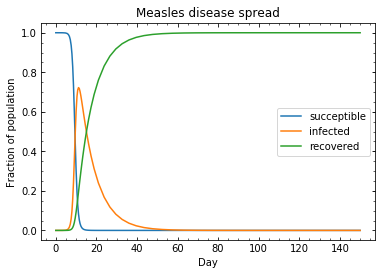

In [142]:
### BEGIN SOLUTION
c = 12.8
gamma = 1/8.
beta = c*gamma
sol = integ.solve_ivp( lambda t,y: sir_model(t, y, beta, gamma), (0, 150), y0,
                       atol=1.0e-6, rtol=1.0e-6 )

plt.plot(sol.t, sol.y[0], label='succeptible')
plt.plot(sol.t, sol.y[1], label='infected')
plt.plot(sol.t, sol.y[2], label='recovered')
plt.title("Measles disease spread")
plt.ylabel("Fraction of population")
plt.xlabel("Day")
plt.legend()
### END SOLUTION

To see the role of innoculation, suppose that we still start with 50% of the population innoculated. This means that 50% of the population starts in the "recovered" group. Let us still start with 10 out of 10 million people with measles (as above). Now set up the initial conditions and solve the system of differential equations for the spread of the disease. Produce a quick plot of the infected fraction versus time, showing both the no innoculation (from above) and 50% innoculation curves.

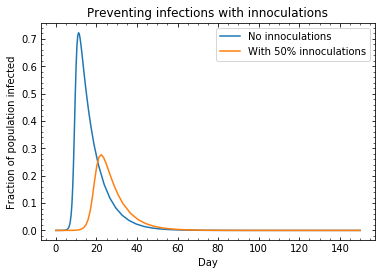

In [141]:
### BEGIN SOLUTION
y02 = np.array([0.5 - 1.0e-6, 1.0e-6, 0.5])
sol2 = integ.solve_ivp( lambda t,y: sir_model(t, y, beta, gamma), (0, 150), y02,
                       atol=1.0e-6, rtol=1.0e-6 )

plt.plot(sol.t, sol.y[1], label='No innoculations')
plt.plot(sol2.t, sol2.y[1], label='With 50% innoculations')
plt.title("Preventing infections with innoculations")
plt.ylabel("Fraction of population infected")
plt.xlabel("Day")
plt.legend()
### END SOLUTION

Your plot should show that 50% innoculation helps, but still a large fraction of the population is infected at the same time. With this simple model we can easily determine the fraction of the population that must be innoculated so that measles does not spread. In fact, we already did this calculation! Looking back to the calculation of $\beta_{\mathrm{min}}$ above, we can write $\beta$ in terms of the contact number and solve for $s(0)$ as a function of $c$ and $\gamma$, as appropriate, which leaves us with a very simple expression,

$$
s_{\rm min}(0) = 1/c\,.
$$

Finally, solve the system of differential equations for the spread of measles, assuming again that only 10 out of 10 million people are infected, but now using the $s_{\rm min}(0)$ value in your initial conditions. Print the percentage of the population that should be innoculated to prevent the spread of measles. Produce a quick plot of the infected fraction of the population versus time and verify that it never increases.

Inocculated population fraction: 0.922


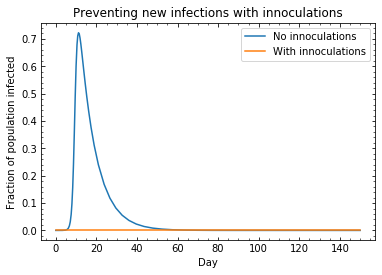

In [140]:
### BEGIN SOLUTION
smin = 1/c
print(f"""Inocculated population fraction: {"%1.3f"%(1-smin)}""")

y02 = np.array([1/c - 1.0e-6, 1.0e-6, 1-1/c])
sol2 = integ.solve_ivp( lambda t,y: sir_model(t, y, beta, gamma), (0, 150), y02,
                       atol=1.0e-6, rtol=1.0e-6 )

plt.plot(sol.t, sol.y[1], label='No innoculations')
plt.plot(sol2.t, sol2.y[1], label='With innoculations')
plt.title("Preventing new infections with innoculations")
plt.ylabel("Fraction of population infected")
plt.xlabel("Day")
plt.legend();
### END SOLUTION

## Member Participation

See Lab 1 for instructions on turning in labs. In the following cell enter the names for each student in the group who partcipated in this lab.